In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import statsmodels.stats.multitest as smt
from scipy.stats import t


In [3]:
def sample_gen( m1 , m2 , sigma1 , mean1 , sigma2 , mean2 ) :

    return np.random.normal(mean1, sigma1, m1) , np.random.normal(mean2, sigma2, m2)


def T(sample1 , sample2) :
    m1 = len(sample1) ; m2 = len(sample2)
    x1 = np.mean(sample1) ; x2 = np.mean(sample2)
    s = np.sqrt(  (np.sum((sample1 - x1)**2) + np.sum((sample2 - x2)**2 ))/(m1+m2-2) )
    return ( x1 - x2 ) / s / np.sqrt(1/m1 + 1/m2)

def p_value( sample1 , sample2) :
    value = np.abs(T(sample1,sample2)) 
    return 2* (1 - t.cdf( value , len(sample1) + len(sample2) - 2)) 

def crit(sample1 , sample2 , alpha=0.05 )  : # соотв alpha = 0.05
    b = t.ppf(alpha/2, len(sample1) + len(sample2) - 2 )
    return np.abs(T(sample1 , sample2)) > b 


In [4]:
def gen_w(alpha , n) :
    return np.random.normal(0, alpha**(-1/2), n)
def gen_X(n ,m , sigma) :
    # print(m ,n , np.random.normal(0, sigma, n*m).shape) 
    return np.random.normal(0, sigma, n*m).reshape(n,m).T
def gen_y(w,X) :
    y = []
    for j in range(X.shape[0]) :

        p = 1/(1 + np.exp(-np.dot(w,X[j])) )
        # print(X[j].shape , w.shape , p.shape , np.random.binomial(n=1, p=p, size=1).shape)
        y.append(np.random.binomial(n=1, p=p, size=1)[0])
    return np.array(y)



In [5]:
from sklearn.metrics import roc_auc_score

### Случай когда мы знаем w

In [6]:
alpha = 0.05
sigma = 0.5
n = 40
m1 = 100
w = gen_w(alpha , n )
X_train = gen_X( n , m1 , sigma)
y_train = gen_y(w , X_train)

print(X_train.shape , y_train.shape)

(100, 40) (100,)


Как видим ожидание AUC медленно,но стремится к единице при $m_2 \rightarrow \inf$

In [42]:
E_auc = []
for m2 in [500,1000,2000,5000] :
    N_sampling = 100
    value = 0
    for _ in range(N_sampling) :
        X_test = gen_X(n , m2 , sigma)
        y_test = gen_y(w , X_test)
        # Знаем w :
        y_preds = 1 / (1 + np.exp(-X_test@w))
        auc_score = roc_auc_score(y_test, y_preds)
        value += auc_score
    E_auc.append(  value / N_sampling)
    print(E_auc[-1])    

0.995704734389161
0.9957952275897171
0.9958172267585126
0.995872862020073


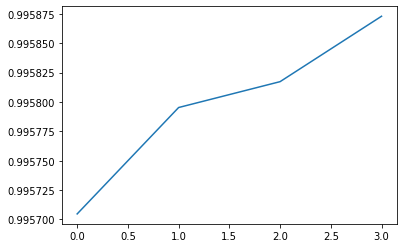

In [43]:
plt.plot(E_auc)

### Пусть теперь мы сгенерили с помощью w , но используем другой независимый w_0

In [21]:
alpha = 0.05
sigma = 0.5
n = 40
m1 = 100
w = gen_w(alpha , n )
X_train = gen_X( n , m1 , sigma)
y_train = gen_y(w , X_train)
print(X_train.shape , y_train.shape)

(100, 40) (100,)


Зависимость E(AUC) от m2

[ 100  400  700 1000 1300 1600 1900]
0.4984700388008266
0.4977438729663616
0.4996726634105432
0.4995323385476005
0.49772805442417156
0.5001849069263565
0.5020726725671554


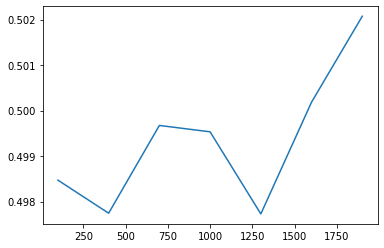

In [34]:
E_auc = []
m_arr = np.arange(100,2000,300)
print(m_arr)
for m2 in  m_arr :
    N_sampling = 1000
    value = 0
    for _ in range(N_sampling) :
        X_test = gen_X(n , m2 , sigma)
        y_test = gen_y(w , X_test)
        w_0 = gen_w(alpha , n )
        y_preds = 1 / (1 + np.exp(-X_test@w_0))
        auc_score = roc_auc_score(y_test, y_preds)
        value += auc_score
    E_auc.append(value / N_sampling)
    print(E_auc[-1])    

plt.plot(m_arr,E_auc)
plt.show()

Как видим в среднем AUC стремится к 0.5